## Libraries

In [24]:
# Determinadas.
import numpy as np
import pandas
import matplotlib.pyplot as plt
import random
import imutils

# Preprocesamientos.
from sklearn import preprocessing

# Modelos.
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Procesamiento de imágenes.
import numpy as np
import cv2
import os
from numpy import mean
from numpy import std

# Control de modelos.
from joblib import dump, load

## Functions

### Main function

In [25]:
def mainFunction(image):
    # Variable a utilizar.
    plate_code = ""
    
    # Sacar figura de la imagen.
    hImg, wImg, cImg = image.shape
    
    # Área de la imagen principal.
    mainImgArea = hImg*wImg
    
    # Copiar la imagen original.
    img_cpy = image.copy()
    
    # Convertir imagen a escala de grises.
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    
    # Aplicar filtro bilateral para suavizar la imagen y eliminar el ruido.
    bilateral = cv2.bilateralFilter(gray, 11, 17, 17)
    
    # Aplicar desenfoque gaussiano.
    blur = cv2.GaussianBlur(bilateral, (5, 5), 0)
    
    # Aplicar umbral adaptativo.
    thresholdImg = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY,21,3)
    
    # Encontrar todos los contornos.
    cnts = cv2.findContours(thresholdImg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Guardar contornos.
    cnts = imutils.grab_contours(cnts)
    
    # Ordenar de manera descendente según el área de los contornos.
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:25]
    
#     cv2.drawContours(image,cnts,-1,(0,0,255),2)
    
    # Por cada contorno.
    for c in cnts:
        # Obtener su área.
        area = cv2.contourArea(c)
        
        # Obtener rectángulo del contorno.
        x, y, w, h = cv2.boundingRect(c)
        
        # Calcular perímetro del contorno.
        epsilon = 0.018 * cv2.arcLength(c, True)
        
        # Encontrar figura aproximada.
        approxFig = cv2.approxPolyDP(c, epsilon, True)
        
        # Si la figura aproximada tiene 4 vértices (es un rectángulo o un cuadrado).
        if len(approxFig) == 4 and area <= mainImgArea*0.5:
            # Sacar la relación de aspecto del rectángulo.
            aspect_ratio  = float(w)/h
            
            # Si la relación de aspecto es la deseada (relación de aspecto de una placa de un automóvil).
            if aspect_ratio >= 1.7 and aspect_ratio <= 5:
                # Obtener la imagen que contiene el rectángulo desde la imagen original (sin procesamiento de imagen).
                plate  = img_cpy[y:y+h, x:x+w]
                
                # Predecir.
                plate_code = GetPlateString(plate)      
                
                if plate_code != None:
                    # Añadir texto.
                    cv2.putText(image, '???'if plate_code is None else str(plate_code), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 0, 0), 2, cv2.LINE_AA)
                
                    # Dibujar rectángulo en la imagen.
                    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    
                    return plate_code, image 
    return None, image

### Principal function to get complete prediction

In [26]:
def GetPlateString(plateImg):
    # Aplicar procesamiento de imagen.
    plateProcessedImg = PlateImageProcessing(plateImg.copy())
    
    # Obtener imágenes de las letras y números de la placa, y sus rectángulos.
    imgns, rectangles = GetComponentsOfPlate(plateImg.copy(), plateProcessedImg.copy())
    
    # Validar que no sean nulo.
    if (len(imgns) == 0 or len(rectangles) == 0):
        return None
    
    # Obtener puntos de interés de los rectángulos.
    interestPoints = GetPointsOfInterestFromRectangles(rectangles.copy())
    
    # Validar que no sean nulo.
    if (len(interestPoints) <= 1):
        return None
    
    # Obtener imágenes adecuadas.
    imgns, rectangles = GetSuitableComponents(imgns.copy(), rectangles.copy(), interestPoints.copy()) 
        
    # Ordenar las imágenes.
    imgns = GetSortedcomponents(imgns.copy(), rectangles.copy())
    
    # Leer imágenes.
    components = ReadImages(imgns)
        
    # Validar que no sea nulo.
    if len(components) == 0:
        return None
    
    # Crear string.
    plateCode = ''.join(map(str,components))
        
    return plateCode

### Plate processing

In [27]:
def PlateImageProcessing(plateImg):
    # Convertir a escala de grises.
    grayImg = cv2.cvtColor(plateImg, cv2.COLOR_BGR2GRAY)

    # Blur.
    blur = cv2.GaussianBlur(grayImg,(3,3),0)

    # Aplicar umbral binario inverso.
    binary = cv2.threshold(blur, 140, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return binary.copy()
    

In [28]:
def GetComponentsOfPlate(plateImg, plateProcessedImg):
    # Obtener contornos.
    countours, hierarchy = cv2.findContours(plateProcessedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sacar forma de la imagen.
    height, width, channels = plateImg.shape
    
    # Validar que hayan contornos.
    if len(countours) == 0:
        return [], []
    
    # Obtener rectángulos.
    rectangles = [cv2.boundingRect(countour) for countour in countours]
    
    # Validar que hayan rectángulos.
    if len(rectangles) == 0:
        return [], []
    
    # Listas a utilizar.
    componentImages = []
    suitableRectangles = []
    
    # Restringir los rectángulos válidos
    for rect in rectangles:
        if (rect[2] >= (width * 0.02) and rect[2] <= (width * 0.3))  and  (rect[3] >= (height * 0.3) and rect[3] <= (height * 0.8)):
            imgn = plateImg[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
            imgn = cv2.resize(imgn, (28, 28))
            componentImages.append(imgn)
            suitableRectangles.append(rect)
            
    # Convertir a np.
    componentImages = np.asarray(componentImages)
    suitableRectangles = np.asarray(suitableRectangles)
    
    return componentImages, suitableRectangles

In [29]:
def GetPointsOfInterestFromRectangles(rectangles):
    # Lista a utilizar.
    interestPoints = []

    # Añadir a la lista los componentes a utilizar (puntos de interés).
    for i in range(len(rectangles)):
        # 3 puntos de interés: Coordenada del punto de origen (Y), coordenada del vértice debajo del origen (Y), altura. 
        interestPoints.append( [rectangles[i,1], rectangles[i,1]+rectangles[i,3], rectangles[i,3]] )
    
    # Normalizar valores.
    interestPoints = preprocessing.normalize(interestPoints)
    
    # Convertir en Dataframe.
    interestPointsDF = pandas.DataFrame(interestPoints)
    
    return interestPointsDF

In [30]:
def GetSortedcomponents(imgns, rectangles):
    # Ordenar imágenes.
    sortedImgns = imgns[rectangles[:, 0].argsort()]
    
    return sortedImgns

In [31]:
def GetSuitableComponents(imgns, rectangles, interestPoints):
    # Agrupamiento jerárquico.
    Z = linkage(interestPoints.values, 'ward')
    
    # Formar grupos en la distancia 0.15
    g = fcluster(Z,criterion='distance',t=0.15)
    
    # Conseguir el índice de grupo.
    groups = np.unique(g)
    
    # Variables a utilizar.
    maxRepeatedGroup = -100
    biggestGroup = 0

    # Buscar el grupo más grande.
    for group in groups:
        if( len(interestPoints[g == group]) > maxRepeatedGroup):
            maxRepeatedGroup = len(interestPoints[g == group])
            biggestGroup = group
    
    # Obtener índices correctos.
    indexes = g == biggestGroup
            
    # Obtener los componentes adecuados.
    suitableImgns = imgns[indexes]
    suitableRectangles = rectangles[indexes]
    
    return suitableImgns, suitableRectangles

### Components processing

In [32]:
def ReadImages(imgns):
    # Procesamiento de imágenes.
    imgnsBinary, imgnsBinaryInv = ComponentImageProcessing(imgns)
    
    # Obtener predicciones de las imágenes en binario.
    binaryImagesComponents, binaryImagesProbabilities = PredictImgns(imgnsBinary)
    
    # Obtener predicciones de las imágenes en binario inverso.
    binaryInvImagesComponents, binaryInvImagesProbabilities = PredictImgns(imgnsBinaryInv)
    
    # Identificar cuál binarización es la correcta.
    components, probabilities = GetCorrectBinarization(binaryImagesComponents, binaryImagesProbabilities, binaryInvImagesComponents, binaryInvImagesProbabilities)
    
    # Lista a utilizar.
    finalComponents = []
    
    # Restringir probabilidades.
    for component, probability in zip(components, probabilities):
        if(probability >= 0.4):
            finalComponents.append(component)
            
    # Validar que la lista no esté vacía.
    if len(finalComponents) == 0:
        return []
    
    return finalComponents

In [33]:
def ComponentImageProcessing(imgns):
    # Listas a utilizar.
    imgnsBinary = []
    imgnsBinaryInv = []
    
    # Iterar para cada imagen.
    for imgn in imgns:
        # Convertir a escala de grises.
        gray = cv2.cvtColor(imgn, cv2.COLOR_BGR2GRAY)
        
        # Blur.
        blur = cv2.GaussianBlur(gray,(7,7),0)

        # Aplicar umbral binario.
        binary = cv2.threshold(blur.copy(), 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        
        # Aplicar umbral binario inverso.
        binaryInv = cv2.threshold(blur.copy(), 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
        # Añadir a las listas.
        imgnsBinary.append(binary)
        imgnsBinaryInv.append(binaryInv)
        
    # Convertir a np.
    imgnsBinary = np.asarray(imgnsBinary)
    imgnsBinaryInv = np.asarray(imgnsBinaryInv)
        
    return imgnsBinary, imgnsBinaryInv

In [34]:
def PredictImgns(imgns):
    # Listas a utilizar.
    probabilities = []
    components = []
    
    # Iterar por cada imagen.
    for imgn in imgns:
        # A una sola dimensión.
        imgnFlat = imgn.flatten()

        # Redimensionar.
        h = imgnFlat.reshape(1,-1)
        
        # Predecir letra.
        YpredLetter = lettersModel.predict(h)

        # Predecir probabilidades de letras.
        YpredLetterProbabilities = lettersModel.predict_proba(h)
        
        # Obtener la mayor probabilidad de letras.
        maxLetterProbability = -np.sort(-YpredLetterProbabilities, axis=1)[0,0]
        
        # Predecir número.
        YpredNumber = numbersModel.predict(h)

        # Predecir probabilidades de números.
        YpredNumberProbabilities = numbersModel.predict_proba(h)
        
        # Obtener la mayor probabilidad de número.
        maxNumberProbability = -np.sort(-YpredNumberProbabilities, axis=1)[0,0]
        
        # Mayor probabilidad de ser una letra.
        if maxLetterProbability > maxNumberProbability:
            probabilities.append(maxLetterProbability)
            components.append(chr(int(YpredLetter)))
        # Mayor probabilidad de ser un número.
        else:
            if maxLetterProbability >= 0.97:
                probabilities.append(maxLetterProbability)
                components.append(chr(int(YpredLetter)))
            else:
                probabilities.append(maxNumberProbability)
                components.append(int(YpredNumber))
            
    # Convertir a np.
    probabilities = np.asarray(probabilities)
    
    return components, probabilities 

In [35]:
def GetCorrectBinarization(binaryImagesComponents, binaryImagesProbabilities, binaryInvImagesComponents, binaryInvImagesProbabilities):
    # Sumar probabilidades de imágenes binario.
    sumBinaryProbabilities = np.sum(binaryImagesProbabilities)
    
    # Sumar probabilidades de imágenes binario inverso.
    sumBinaryInvProbabilities = np.sum(binaryInvImagesProbabilities)
    
    # Saber cuál binarización tiene la mayor suma de probabilidades.
    if sumBinaryProbabilities > sumBinaryInvProbabilities:
        return binaryImagesComponents, binaryImagesProbabilities
    else:
        return binaryInvImagesComponents, binaryInvImagesProbabilities

## Import models

In [36]:
lettersModel = load('Models/SVC Models/Complex_Letters_SVC_Model.joblib') 
numbersModel = load('Models/SVC Models/Complex_Numbers_SVC_Model.joblib') 

## Experiment 1 - Predict one image

### Load image and predict

In [37]:
# Ruta de la imagen.
path = r'Experiments datasets\Car plates with car\DZ17YXR.png'

# Cargar imagen.
carImgExperiment = cv2.imread(path)

# Predecir imagen.
codeResult, img = mainFunction(carImgExperiment)

### Show image

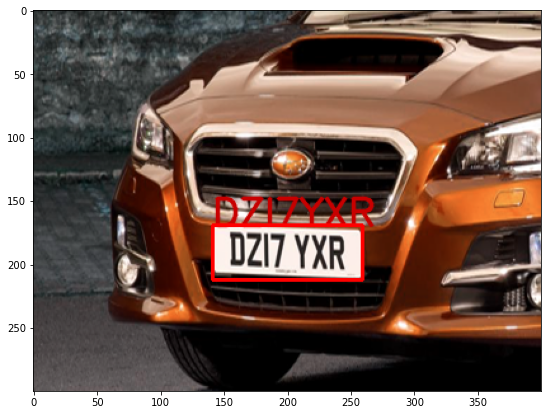

DZI7YXR


In [38]:
# Mostrar imagen.
if len(img) == 0:
    print("No se detectó la placa.")
else:
    plt.figure(figsize=(10,7))
    plt.imshow(img)
    plt.show()

# Imprimir resultado.
if codeResult == None:
    print("No se pudo leer.")
else:
    print(codeResult)